## Code to process the XYZ files and generate resumen

In [3]:
import os
import numpy    as     np
from   tabulate import tabulate

###########################################
###       All canversion rates          ###
###########################################

# Some constants 
c_cm_s    = 2.998e+10       # cm/s
h_bar     = 1.054571817e-34 # J*s

# Conversions from atomic unit
autoev   = 27.211383858491185
autoj    = 4.35974394e-18 
autocmm1 = 219474.63133081
autofs   = 0.02418884326505
autos    = 2.418884326505e-17
autoan   = 0.52917720859
autocm   = 0.52917720859e-8
autoamu  = 0.0005485799092659504
autoanf  = 21.876912541518593
autoamuA = autoamu * autoan**2 # Convert from atomic units to amu*Å^2

# Conversions to atomic unit
evtoau   = 0.03674932540
jtoau    = 2.293712689924629e+017
cmm1toau = 4.556335252760e-06
fstoau   = 41.341373336561364
stoau    = 4.134137333656137e+16
antoau   = 1.8897261328856432
cmtoau   = 188972613.28856432
amutoau  = 1822.888485540950
anftoau  = 0.045710289242239875

# Others conversions
ev_to_J  = 1.60218e-19
degtorad = 180 / np.pi
Antom    = 1e-10
amutoKg  = 1.66054e-27
Afstoms  = 1e5
mstoafs  = 1e-5


##########################################
###           All methods use          ###
##########################################

def get_NO_massCenter(N_pos, O_pos):
    massCenter_coord = []
    for i in range(3):
        massCenter_coord.append((N_mass * N_pos[i] + O_mass * O_pos[i])/(N_mass + O_mass))
    return massCenter_coord

def get_NO2_massCenter(N_pos, O1_pos, O2_pos):
    massCenter_coord = []
    for i in range(3):
        massCenter_coord.append((N_mass * N_pos[i] + O_mass * (O1_pos[i] + O2_pos[i]))/(N_mass + 2 * O_mass))
    return massCenter_coord

def get_distance(P1, P2):
    return np.sqrt((P1[0] - P2[0])**2 + (P1[1] - P2[1])**2 + (P1[2] - P2[2])**2)

def parse_XYZ(file_name):
    xyz_file = open(file_name, 'r')
    lines    = xyz_file.readlines()
    xyz_file.close()
  
    # Extract the data from the XYZ file
    n_atoms     = int(lines[0])
    cfg         = int(np.ceil(len(lines)/(n_atoms + 2)))
    properties  = []
    coordinates = []
    velocities  = []
    for i in range(cfg):
        comments_line = np.array(lines[i * (n_atoms + 2) + 1].split())
        properties.append(comments_line[14:])
        for j in range(2, n_atoms + 2):
            atom_line = np.array(lines[i * (n_atoms + 2) + j].split())
            coordinates.append(atom_line[1:4])
            velocities.append(atom_line[4:7]) 
    properties  = np.array(properties)
    coordinates = np.array(coordinates, dtype=float)
    velocities  = np.array(velocities, dtype=float)
    return properties, coordinates, velocities

def get_L3_z(coordinates):   
    n = 0
    z = 0
    for atom in coordinates[3:]:
        if atom[2] > 5 * antoau:
            z += atom[2]
            n += 1
    return z / n

def cartesian_to_spherical(coord):
    r     = np.sqrt(sum([c**2 for c in coord]))
    theta = np.degrees(np.arccos(coord[2] / r))
    phi   = np.degrees(np.arctan2(coord[1], coord[0]))
    if phi < 0 and coord[1] < 0:
        phi += 360  # Adjust phi for the third and fourth quadrants
    return [r, theta, phi ]

def get_morsePotential(r, De, a, re ):
    return De * (1 - np.exp(-a*(r-re)))**2

def get_energyVib(n, mu, De, k):
    return h_bar * np.sqrt(k/mu) * (n + 1/2) - (n + 1/2)**2 * h_bar * np.sqrt(k/mu) / (4 * De)

def get_I_Tensor(positions, masses):
    """Compute the moment of inertia tensor for a molecule."""
    I = np.zeros((3, 3))
    for pos, mass in zip(positions, masses):
        for i in range(3):
            for j in range(3):
                if i == j:
                    I[i, j] += mass * (np.sum(pos**2) - pos[i]**2)
                else:
                    I[i, j] -= mass * pos[i] * pos[j]
    return I

def get_jr_mol(coord, velocities, masses):
    L = np.zeros(3)
    for i in range(len(masses)):
        r = coord[i]
        v = velocities[i]
        L += masses[i] * np.cross(r, v)    
    return L

def get_NO2_rot_const(inertia_tensor):
    # Diagonalize the inertia tensor to find the principal moments of inertia
    eigenvalues, _ = np.linalg.eigh(inertia_tensor)
    
    # Sort the eigenvalues just in case they are not in ascending order
    I_x, I_y, I_z = np.sort(eigenvalues) 
    
    return [1 / I_x, 1 / I_y, 1 / I_z, I_x * I_y * I_z] # [A, B, C, I_xyz] calculation made in atomic units

def get_Params(coord, velocity):
    '''
    Get the most important distances and angles
    '''
    
    # Convert to atomic unit the input data
    coord          *= antoau
    velocity       *= anftoau
    
    # Get distances between O2 and the bounded carbons atoms C1, C2
    q_O2C1_norm           = np.linalg.norm(coord[2] - coord[97])     # au (distance)
    q_O2C2_norm           = np.linalg.norm(coord[2] - coord[79])     # au (distance)
    
    #Set positions and velocities easier to use
    q_N                   = coord[0]
    q_O1                  = coord[1]
    q_O2                  = coord[2]
    v_N                   = velocity[0]
    v_O1                  = velocity[1]
    v_O2                  = velocity[2]
    
    # Get intermolecular vector N and O1
    q_NO1                 = q_O1 - q_N                    # vector
    q_NO1_norm            = np.linalg.norm(q_NO1)         # au (distance)
    q_NO1_direction       = q_NO1/np.linalg.norm(q_NO1)   # unitary vector
    
    # Get vector and direction between N and O2
    q_NO2                 = q_O2 - q_N                    # vector
    q_NO2_norm            = np.linalg.norm(q_NO2)         # au (distance)
    q_NO2_direction       = q_NO2/q_NO2_norm              # unitary vector
    
    # Get vector and direction between O1 and O2
    q_O1O2                = q_O2 - q_O1                    # vector
    q_O1O2_norm           = np.linalg.norm(q_O1O2)         # au (distance)
    q_O1O2_direction      = q_O1O2/q_O1O2_norm             # unitary vector
    
    # Nitrogen and O1 velocities in the interatomic direction
    N_inter_vel           = np.dot(v_N, q_NO1_direction)   # au (velocity)
    O1_inter_vel          = np.dot(v_O1, q_NO1_direction)  # au (velocity)
    
    # Nitrogen and O2 velocities in the interatomic direction
    N_O2_inter_vel        = np.dot(v_N, q_NO2_direction)   # au (velocity)
    O2_inter_vel          = np.dot(v_O2, q_NO2_direction)  # au (velocity)
    
    # Nitrogen and O2 velocities in the interatomic direction
    O1toO2_inter_vel      = np.dot(v_O1, q_O1O2_direction) # au (velocity)
    O2toO1_inter_vel      = np.dot(v_O2, q_O1O2_direction) # au (velocity)
    
    # Reactive trajectory or not
    NO2_form              = True if (q_NO2_norm < q_O2C1_norm and q_NO2_norm < q_O2C1_norm) else False
    
    # Center of mass params
    mol_mass              = ( N_mass + 2 * O_mass ) * amutoau   if NO2_form else ( N_mass + O_mass ) * amutoau # au (mass)
    mol_massCenter        = get_NO2_massCenter(q_N, q_O1, q_O2) if NO2_form else get_NO_massCenter(q_N, q_O1)  # coordinates
    mol_mCenter_vel       = get_NO2_massCenter(v_N, v_O1, v_O2) if NO2_form else get_NO_massCenter(v_N, v_O1)  # vector
    mol_mCenter_vel_norm  = np.linalg.norm(mol_mCenter_vel)                                                    # au (velocity)
    
    # Molecule High respect HOPG surface
    d_mol_L3              = mol_massCenter[2] - get_L3_z(coord) # au (distance)
    
    # Determine the ouput channel: NO2 scattered output_CH = 0, NO2 adsorbed output_CH = 1, NO scattered output_CH = 2, NO adsorbed output_CH = 3
    output_CH             = 0 if (NO2_form and (d_mol_L3 * autoan) >= (detector_high - 0.1 )) else 1 if (NO2_form and (d_mol_L3 * autoan) < detector_high) else 2 if (NO2_form == False and (d_mol_L3 * autoan) >= (detector_high - 0.1 )) else 3
    
    # Distance from the molecule to O2
    q_molO2               = q_O2 - mol_massCenter    # vector
    q_molO2_norm          = np.linalg.norm(q_molO2)  # au (distance) 
        
    # Movement quantity and rotational vectors using methods from clasical phisycs
    pr_NO1                = mu_NO1_au * (v_O1 - v_N)                              # Compute p for NO diatom (pr_NO1) in [au]
    jr_mol                = np.cross(pr_NO1, q_NO1) if NO2_form == False else get_jr_mol(np.array([q_N, q_O1, q_O2]) - mol_massCenter, np.array([v_N, v_O1, v_O2]) - mol_mCenter_vel, np.array([N_mass, O_mass, O_mass]) * amutoau)  # Compute angular momentum [vector]
    pr_NO1_inter          = np.dot(pr_NO1, q_NO1_direction)                       # Compute p in the interatomic direction [au]
    jr_mol_norm           = np.linalg.norm(jr_mol)                                # Angular momentum [au]
    
    if NO2_form:
        # Calculate the Moment of Inertia Tensor
        mol_I             = get_I_Tensor(np.array([q_N, q_O1, q_O2]) - mol_massCenter, np.array([N_mass, O_mass, O_mass]) * amutoau)
        NO2_rot_const     = get_NO2_rot_const(mol_I)
        try:
            mol_w         = np.linalg.solve(mol_I, jr_mol)  # Angular velocity from solving the equation L = Iw
        except np.linalg.LinAlgError:
            # Handle singular matrix error
            mol_w         = 0
    else:
        NO2_rot_const = [0, 0, 0, 0]
    
    # Get molecule velocity orientation     
    mol_vel_theta         = np.degrees(np.arccos(mol_mCenter_vel[2]/np.linalg.norm(mol_mCenter_vel)))                              # degree
    mol_vel_phi           = np.degrees(np.arccos(mol_mCenter_vel[0]/np.linalg.norm([mol_mCenter_vel[0], mol_mCenter_vel[1], 0])))  # degree 
    mol_vel_Sphe          = cartesian_to_spherical(mol_mCenter_vel)                                                                # spherical coordinates
    
    # Get NO theta and phi angles by analitic geometry equations
    NO1_theta             = np.degrees(np.arccos(q_NO1[2]/np.linalg.norm(q_NO1)))                    # degree
    NO1_phi               = np.degrees(np.arccos(q_NO1[0]/np.linalg.norm([q_NO1[0], q_NO1[1], 0])))  # degree
    
    # Get NO theta and phi angles by spheric coordinates equations
    O1_pos                = q_O1 - mol_massCenter       # vector
    O1_Spheric            = cartesian_to_spherical(O1_pos)  # spherical coordinates
    
    # Get NO angles of inclination respect the O2-CM
    Module_prod           = np.linalg.norm(q_NO1) * np.linalg.norm(q_molO2)            # au (distance)
    NO1_O2CM_phi          = np.degrees(np.arccos(np.dot(q_molO2, q_NO1)/Module_prod))  # degree
    
    # Get O-N-O angle
    Module_prod           = np.linalg.norm(q_NO1) * np.linalg.norm(q_NO2)              # au (distance)
    ONO_phi               = np.degrees(np.arccos(np.dot(q_NO1, q_NO2)/Module_prod))    # degree
    
    # Get NO_CM - O inclination respect normal
    O2CM_z_phi            = np.degrees(np.arccos(q_molO2[2]/np.linalg.norm(q_molO2)))  # degree
    
    # Molecule kinetic energy
    mol_Ekin              = 1/2 * mol_mass * np.square(mol_mCenter_vel_norm)                                  # au (energy)
    
    # Molecule potential energy
    mol_Epot              = get_morsePotential(q_NO1_norm * autoan, De, a, re)    if NO2_form == False else 0 # eV
    
    # Molecule vibratonial energy
    mol_Evib              = (np.square(pr_NO1_inter)/(2 * mu_NO1_au))             if NO2_form == False else 0 # au (energy)
    
    # Molecule rotational energy
    #mol_Erot              = 1/(2 * mu_NO1_au) * np.square(jr_NO1_norm/q_NO1_norm) if NO2_form == False else 0 # au (energy)
    mol_Erot              = 1/(2 * mu_NO1_au) * np.square(jr_mol_norm/q_NO1_norm) if NO2_form == False else 0.5 * np.dot(mol_w, np.dot(mol_I, mol_w)) # au (energy)
    
    # Quantum rotational number j
    jrotcont              =(-1.0 + np.sqrt(1.0 + 4.0 * jr_mol_norm**2)) * 0.5
    jrotf                 = np.ceil(jrotcont)
    
    # Getting values back from au
    for i, elem in enumerate(mol_massCenter):
        elem               *= autoan  
        mol_massCenter[i]  *= autoan
        mol_mCenter_vel[i] *= autoanf
    coord          *= autoan
    velocity       *= autoanf
    NO2_ABC        = [var * autocmm1 for var in NO2_rot_const[:-1]]
    
    # Create a dictionary with the calculated data
    data = {
        'output'          : output_CH                       ,
        'mol_massCenter'  : mol_massCenter                  ,
        'mol_mCenter_vel' : mol_mCenter_vel                 ,
        'mol_jrot'        : jrotf                           ,
        'NO2_ABC'         : NO2_ABC                         ,
        'NO2_I_xyz'       : NO2_rot_const[-1]  * autoamuA**3,
        'NO1_theta'       : round(O1_Spheric[1]         , 2),
        'NO1_phi'         : round(O1_Spheric[2]         , 2),
        'NO1_theta_a'     : round(NO1_theta             , 2),
        'NO1_phi_a'       : round(NO1_phi               , 2),
        'd_NO1'           : round(q_NO1_norm   * autoan , 4),
        'd_NO2'           : round(q_NO2_norm   * autoan , 4),
        'd_molO2'         : round(q_molO2_norm * autoan , 4),
        'd_O2C1'          : round(q_O2C1_norm  * autoan , 4),
        'd_O2C2'          : round(q_O2C2_norm  * autoan , 4),
        'd_mol_L3'        : round(d_mol_L3     * autoan , 4),
        'NO1_O2CM_phi'    : round(NO1_O2CM_phi          , 2),
        'ONO_phi'         : round(ONO_phi               , 2),
        'O2CM_z_phi'      : round(O2CM_z_phi            , 2),
        'mol_vel_theta'   : round(mol_vel_Sphe[1]       , 2),
        'mol_vel_phi'     : round(mol_vel_Sphe[2]       , 2),
        'mol_vel_theta_a' : round(mol_vel_theta         , 2),
        'mol_vel_phi_a'   : round(mol_vel_phi           , 2),
        'mol_Ekin'        : round(mol_Ekin * autoev     , 4),
        'mol_Epot'        : round(mol_Epot              , 4),
        'mol_Evib'        : round(mol_Evib * autoev     , 4),
        'mol_Erot'        : round(mol_Erot * autoev     , 4)
    }
    return data


################################    
### Here start the action    ###
################################

# Some variables and arrays needed to the code 
#E            = [0.025, 0.05, 0.1, 0.3] # eV

print()
Energy_input  = input("Enter the energy value in eV separated by commas: ")
E             = [e.strip() for e in Energy_input.split(',')]

n_atoms       = 99
out_ch_count  = []

# Types of XYZ files
xyz_name      = ["Start"        , "IS"           , "TS"          , "Turn_Point"   , "FS"           , "NO2_End"    , "End"          ]

# Headers for the tables
Header_all    = ["Tray"         , "NO1cm_x"      , "NO1cm_y"     , "NO1_theta (°)", "NO1_phi (°)"  , "ONO (°)"      , "V_theta (°)",
                 "V_phi (°)"    , "TP_time(fs)"  , "End_time(fs)", "Output"       , "Vel_x(Å/fs)"  , "Vel_y(Å/fs)"  , "Vel_z(Å/fs)",
                 "Mol high(Å)"  , "Ekin(eV)"     , "Evib(eV)"    , "j rot"        ,"Scat_angle(°)" , "Et_f-Et_0(eV)", 'E_rot(eV)'  ,
                 "Bounces"      ]
Header_react  = ["Tray"         , "State"        , "time(fs)"    , "dNO1(Å)"      , "dNO2(Å)"      , "dCMO2(Å)"     , 
                 "dO2C1(Å)"     , "dO2C2(Å)"     , "dmolL3(Å)"   , "ONO_angle(°)" ]
Header_state  = ["Tray"         , "time(fs)"     , "dNO1(Å)"     , "dNO2(Å)"      , "dCMO2(Å)"     , "dO2C1(Å)"     , "dO2C2(Å)"   ,
                 "Mol high(Å)"  , "ONO_angle(°)", "VcmZ_angle(°)", "Epot_f(eV)"   , "Ekin(eV)"     , "Evib(eV)"     , "j rot"      ,
                 "Bounces"]
Header_prob   = ["Energy"       , "n_tray"       , "NO2 formed"  , "NO2 emitted"  , "NO2 adsorbed" , "NO emitted" , 
                 "NO adsorbed"  , "NO2 formed(%)", "NO2 emit(%)" , "NO2 adsor(%)" , "NO emit(%)"   , "NO adsor(%)"]
Header_rot    = ['Tray'         ,'Output'       , r'A($cm^{-1}$)', r'B($cm^{-1}$)', r'C($cm^{-1}$)', r'I$_{XYZ}$ ($amu^3 Å^6$)']
Header_rTray  = ["Trayectory"] + [f"E = {elem} eV" for elem in E]

# Dictionary array to store all the information from the XYZ files
results       = {f"{name}_{elem}": [] for elem in ["prop", "coord", "vel"] for name in xyz_name}

# Some constants
O_mass        = 15.9999    # u
N_mass        = 14.0067    # u
O_kg_mass     = 2.6561e-26 # Kg
N_kg_mass     = 2.3250e-26 # Kg
mu_NO1_amu    = N_mass * O_mass / (N_mass + O_mass)
mu_NO1_au     = mu_NO1_amu * amutoau
mu_NO1        = N_kg_mass * O_kg_mass / (N_kg_mass + O_kg_mass) # Kg (Reduced mass of diatom)

# Constant for the Morse potential
De, a, re = [7.645438936565258, 2.565143344509797, 1.17028471793808]

print()
Oxy_pbc       = input("Write 0 if interaction with multiple adsorbed oxygens are allowed and 1 if not : ")
slab_pbc      = True if Oxy_pbc == '0' else False 

print()
detector_high = float(input("Enter the high (Å) over HOPG to consider the molecule scattered (0 to stop at the end of the simulation): "))

print()
Orient_input  = input("Write 0 if the NO molecule initial orientation is normal to HOPG surface and 1 if not : ")
orient_type   = ["normal", "oriented"]
AIMD_type     = "AIMD_" + orient_type[int(Orient_input)] + "_incidence_noSpin/"
print()

conditions = ("PBC_" if slab_pbc else "noPBC_") + str(detector_high) + "A" 

for i, energy in enumerate(E):
    # Load all the xyz files to results array
    for name in xyz_name:
        file = AIMD_type + "XYZ_files_" + conditions + "/" + str(energy) + "eV_Tray_" + name + ".xyz"
        prop, coord, vel = parse_XYZ(file)
        results[f"{name}_prop"].append(prop)
        results[f"{name}_coord"].append(coord)
        results[f"{name}_vel"].append(vel)
    
    #################################################
    ###     Get resume of all trayectories        ###
    #################################################
    
    Get_all_Tray     = True
    if Get_all_Tray:       
        table        = []
        table_NO2    = []
        O2_coord     = []
        for j, tray in enumerate(results["Start_prop"][i]):
            params_0 = get_Params(results["Start_coord"][i][j*n_atoms:(j+1)*n_atoms], results["Start_vel"][i][j*n_atoms:(j+1)*n_atoms])
            #print(180 - params_0['mol_vel_theta'], params_0['mol_vel_phi'] - 180)
            #print(params_0['mol_vel_theta_a'], params_0['mol_vel_phi_a'])
            params_f = get_Params(results["End_coord"][i][j*n_atoms:(j+1)*n_atoms], results["End_vel"][i][j*n_atoms:(j+1)*n_atoms])
            table.append([tray[0]                                    , round(params_0['mol_massCenter'][0], 4) , round(params_0['mol_massCenter'][1], 4), params_0['NO1_theta']               , 
                          params_0['NO1_phi']                        , params_0['ONO_phi']                     , 180 - params_0['mol_vel_theta_a']      , params_0['mol_vel_phi_a']           , 
                          results["Turn_Point_prop"][i][j][1]        , results["End_prop"][i][j][1]            , params_f['output']                     , round(params_f['mol_mCenter_vel'][0], 5),
                          round(params_f['mol_mCenter_vel'][1], 5)   , round(params_f['mol_mCenter_vel'][2], 5), params_f['d_mol_L3']                   , params_f['mol_Ekin']                ,
                          params_f['mol_Evib'] + params_f['mol_Epot'], params_f['mol_jrot']                    , params_f['mol_vel_theta_a']            , float(results["End_prop"][i][j][3]) - float(tray[3]),
                          params_f['mol_Erot']                       , results["End_prop"][i][j][7]])
            if params_f['output'] < 2:
                table_NO2.append([tray[0], params_f['output'], params_f['NO2_ABC'][0], params_f['NO2_ABC'][1], params_f['NO2_ABC'][2], params_f['NO2_I_xyz']])
            #print(180 - params_0['mol_vel_theta_a'], params_0['O2CM_z_phi'])
        
        if not os.path.exists(AIMD_type + "Results_" + conditions + "/"):
            os.makedirs(AIMD_type + "Results_" + conditions + "/")
        
        with open(AIMD_type + "Results_" + conditions + "/" + str(energy) + "eV_all_Tray.dat", 'w') as f:
            # Write the table to the file using the tablefmt parameter
            f.write(tabulate(table, Header_all, tablefmt="plain", stralign="center", numalign="center"))
            f.close()       
        
        with open(AIMD_type + "Results_" + conditions + "/" + str(energy) + "NO2_Const.dat", 'w') as f:
            # Write the table to the file using the tablefmt parameter
            f.write(tabulate(table_NO2, Header_rot, tablefmt="plain", stralign="center", numalign="center"))
            f.close() 
        
    ##################################################
    ###     Get resume of reactive trayectories    ###
    ##################################################
    
    Get_react_Trayectories = False
    if Get_react_Trayectories:
        table = []
        for j, tray in enumerate(results["NO2_End_prop"][i]):
            for k, name in enumerate(xyz_name[1:-1]):
                params = get_Params(results[f"{name}_coord"][i][j*n_atoms:(j+1)*n_atoms], results[f"{name}_vel"][i][j*n_atoms:(j+1)*n_atoms])
                table.append([(tray[0] if k == 0 else " "), ("TP" if name == "Turn_Point" else "End" if name == "NO2_End" else name), results[f"{name}_prop"][i][j][1], 
                              params['d_NO1']             , params['d_NO2'], params['d_molO2'], params['d_O2C1'], params['d_O2C2']  , params['d_mol_L3']              ,
                              params['ONO_phi']])
            table.append(['--------'] * len(Header_react))
        with open(AIMD_type + "Results_" + conditions + "/" + str(energy) + "eV_react_Tray.dat", 'w') as f:
            f.write(tabulate(table, Header_react, tablefmt="pipe", stralign="center", numalign="center"))
            f.close()

    ##########################################################
    ###     Get resume of states for react trayectories    ###
    ##########################################################
    
    Get_state_react_Trayectories = True
    if Get_state_react_Trayectories:       
        for j, name in enumerate(xyz_name[1:-1]):
            table = [] 
            for k, tray in enumerate(results["NO2_End_prop"][i]):
                params = get_Params(results[f"{name}_coord"][i][k*n_atoms:(k+1)*n_atoms], results[f"{name}_vel"][i][k*n_atoms:(k+1)*n_atoms])
                table.append([tray[0]                         , results[f"{name}_prop"][i][k][1]       , params['d_NO1']   , params['d_NO2']   , params['d_molO2']      , 
                              params['d_O2C1']                , params['d_O2C2']                       , params['d_mol_L3'], params['ONO_phi'] , params['mol_vel_phi_a'], 
                              results[f"{name}_prop"][i][k][5], params['mol_Ekin'], params['mol_Evib'] + params['mol_Epot'], params['mol_jrot'], results[f"{name}_prop"][i][k][7]])           
            with open(AIMD_type + "Results_" + conditions + "/" + str(energy) + "eV_" + name + "_Tray.dat", 'w') as f:
                f.write(tabulate(table, Header_state, tablefmt="plain", stralign="center", numalign="center"))
                f.close()
    
#####################################################
###     Get probabities for react trayectories    ###
#####################################################

table_prob = []
for energy in E:
    out_ch_count = [int(0) for i in range(4)]
    file = np.loadtxt(AIMD_type + "Results_" + conditions + "/" + str(energy) + "eV_all_Tray.dat", skiprows=1)
    for row in file:
        out_ch_count[int(row[10])] += 1
    n_tray = len(file)
    table_prob.append([energy                    , n_tray                    , out_ch_count[0] + out_ch_count[1]             , out_ch_count[0]           , out_ch_count[1]           , 
                       out_ch_count[2]           , out_ch_count[3]           , (out_ch_count[0] + out_ch_count[1])/n_tray*100, out_ch_count[0]/n_tray*100, out_ch_count[1]/n_tray*100, 
                       out_ch_count[2]/n_tray*100, out_ch_count[3]/n_tray*100])
with open(AIMD_type + "Results_" + conditions + "/React_Prob.dat", 'w') as f:
    f.write(tabulate(table_prob, Header_prob, tablefmt="plain", stralign="center", numalign="center"))
    f.close() 

#####################################################
###     Get wich trayectory react for each energy ###
#####################################################

rTray       = []
table_rTray = []

# Load the files with reactive trayectories for each energy
for i, elem in enumerate(E):
    data  = np.loadtxt(AIMD_type + "Results_" + conditions + "/" + str(elem) + "eV_NO2_End_Tray.dat", skiprows=1)
    rTray.append(data[:, 0])

rTray_all = np.unique(np.concatenate(rTray))   # Get all reactive trayectories

# Check for wich energy the trayectory was reactive
for tray in rTray_all:
    row = []
    for i in range(len(E)):
        row.append(1 if tray in rTray[i] else 0)
    row = [tray] + row
    table_rTray.append(row)

# Write a file with the results 
with open(AIMD_type + "Results_" + conditions + "/TrayR_eachE.dat", 'w') as f:
    f.write(tabulate(table_rTray, Header_rTray, tablefmt="plain", stralign="center", numalign="center"))
    f.close() 

print('Done !!!')





Enter the energy value in eV separated by commas: 0.025, 0.05, 0.1, 0.3

Write 0 if interaction with multiple adsorbed oxygens are allowed and 1 if not : 0

Enter the high (Å) over HOPG to consider the molecule scattered (0 to stop at the end of the simulation): 7

Write 0 if the NO molecule initial orientation is normal to HOPG surface and 1 if not : 1

Done !!!


In [15]:
for i, energy in enumerate([E[0]]):
    print(AIMD_type)
    for j, name in enumerate(xyz_name[1:-1]):
        print()
        state_file = np.loadtxt(AIMD_type + "Results_" + conditions + "/" + str(energy) + "eV_" + name + "_Tray.dat", skiprows=1)
        for tray in state_file:
            tray_file  = np.loadtxt(AIMD_type + "Tray_Resume/" + str(energy) + "_Trayectory_" + str(int(tray[0])) + ".dat", skiprows=1)
            
            if tray[-1] != tray_file[int(tray[1])-1][-1]:
                print("In file", name, "For trajectory", tray[0], "j rot at state_file", tray[-1], "tray file", tray_file[int(tray[1])-1][-1], "at", tray[1], "fs")
        
        

AIMD_oriented_incidence_noSpin/


In file TS For trajectory 64.0 j rot at state_file 0.0 tray file 20.0 at 3452.0 fs
In file TS For trajectory 151.0 j rot at state_file 0.0 tray file 24.0 at 995.0 fs
In file TS For trajectory 166.0 j rot at state_file 0.0 tray file 12.0 at 1217.0 fs

In file Turn_Point For trajectory 4.0 j rot at state_file 26.0 tray file 0.0 at 1222.0 fs
In file Turn_Point For trajectory 6.0 j rot at state_file 8.0 tray file 0.0 at 1117.0 fs
In file Turn_Point For trajectory 9.0 j rot at state_file 1.0 tray file 17.0 at 1006.0 fs
In file Turn_Point For trajectory 10.0 j rot at state_file 0.0 tray file 3.0 at 1037.0 fs
In file Turn_Point For trajectory 16.0 j rot at state_file 7.0 tray file 14.0 at 1124.0 fs
In file Turn_Point For trajectory 23.0 j rot at state_file 0.0 tray file 14.0 at 1116.0 fs
In file Turn_Point For trajectory 24.0 j rot at state_file 12.0 tray file 0.0 at 1229.0 fs
In file Turn_Point For trajectory 50.0 j rot at state_file 15.0 tray file 0.0 at 12

## Code to plot the desire configuration

Enter the energy value in eV separated by commas:  0.3


From <Start or End>; write the type of configuration to show  Start


Enter the trayectory to plot 208


Write 0 if interaction with multiple adsorbed oxygens are allowed and 1 if not :  0


Enter the high (Å) over HOPG to consider the molecule scattered (0 to stop at the end of the simulation):  7


Write 0 if the NO molecule initial orientation is normal to HOPG surface and 1 if not :  1


['0.3']


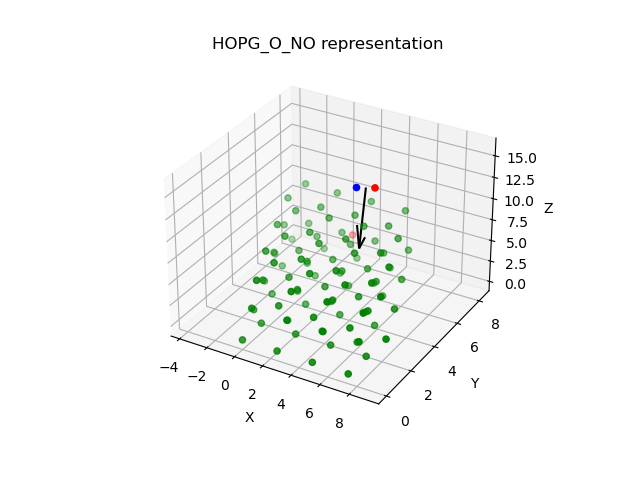

In [18]:
%matplotlib widget
import ipywidgets        as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure and axis object
def get_cfg_plot(cfg):
    fig = plt.figure()
    ax  = fig.add_subplot(111, projection='3d')

    # Create a scatter plot with the data
    ax.scatter(cfg[0, 0], cfg[0, 1], cfg[0, 2], c='blue', marker='o')
    ax.scatter(cfg[1:3, 0], cfg[1:3, 1], cfg[1:3, 2], c='red', marker='o')
    ax.scatter(cfg[3:, 0], cfg[3:, 1], cfg[3:, 2], c='green', marker='o')

    # Set axis labels and a title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('HOPG_O_NO representation')

    # Show the plot
    plt.show()
    
def get_cfg_vel_plot(cfg, vel_cfg, mol):
    fig = plt.figure()
    ax  = fig.add_subplot(111, projection='3d')

    # Create a scatter plot with the data
    if mol == "NO2":
        NO2_massCenter = get_NO2_massCenter(cfg[0], cfg[1], cfg[2])
        NO2_vel        = get_NO2_massCenter(vel_cfg[0], vel_cfg[1], vel_cfg[2])
        NO2_vel_dir    = NO2_vel / np.linalg.norm(NO2_vel)
        NO2_vel_dir   *= 8
        ax.quiver(NO2_massCenter[0], NO2_massCenter[1], NO2_massCenter[2], NO2_vel_dir[0], NO2_vel_dir[1], NO2_vel_dir[2], color='b')
        #ax.scatter(NO2_massCenter[0], NO2_massCenter[1], NO2_massCenter[2], c='black', marker='o')
    elif mol == "NO":
        #print(cfg[0], cfg[1])
        NO_massCenter  = get_NO_massCenter(cfg[0], cfg[1])      
        NO_vel         = get_NO_massCenter(vel_cfg[0], vel_cfg[1])
        NO_vel_dir     = NO_vel / np.linalg.norm(NO_vel)
        NO_vel_dir    *= 8
        ax.quiver(NO_massCenter[0], NO_massCenter[1], NO_massCenter[2], NO_vel_dir[0], NO_vel_dir[1], NO_vel_dir[2], color='black')#, arrow_length_ratio=0.1)
        #ax.plot([NO_massCenter[0], cfg[2][0]], [NO_massCenter[1], cfg[2][1]], [NO_massCenter[2], cfg[2][2]], linestyle='--', color='b')
        #ax.scatter(NO_massCenter[0], NO_massCenter[1], NO_massCenter[2], c='black', marker='o')
    
    ax.scatter(cfg[0, 0], cfg[0, 1], cfg[0, 2], c='blue', marker='o')
    ax.scatter(cfg[1:3, 0], cfg[1:3, 1], cfg[1:3, 2], c='red', marker='o')
    ax.scatter(cfg[3:, 0], cfg[3:, 1], cfg[3:, 2], c='green', marker='o')

    # Set axis labels and a title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('HOPG_O_NO representation')

    # Show the plot
    plt.show()

n_atoms       = 99
O_mass        = 15.9999    # u
N_mass        = 14.0067    # u
# Types of XYZ files
xyz_name      = ["Start", "IS", "TS", "Turn_Point", "FS", "NO2_End", "End"]

# Dictionary array to store all the information from the XYZ files
results       = {f"{name}_{elem}": [] for elem in ["prop", "coord", "vel"] for name in xyz_name}

print()
Energy_input  = input("Enter the energy value in eV separated by commas: ")
E             = [e.strip() for e in Energy_input.split(',')]
i             = 0 if E == 0.025 else 1 if E == 0.05 else 2 if E == 0.1 else 3

print()
XYZ_type      = input("From <Start or End>; write the type of configuration to show ")

print()
j             = int(input("Enter the trayectory to plot"))

print()
Oxy_pbc       = input("Write 0 if interaction with multiple adsorbed oxygens are allowed and 1 if not : ")
slab_pbc      = True if Oxy_pbc == '0' else False 

print()
detector_high = float(input("Enter the high (Å) over HOPG to consider the molecule scattered (0 to stop at the end of the simulation): "))

print()
Orient_input  = input("Write 0 if the NO molecule initial orientation is normal to HOPG surface and 1 if not : ")
orient_type   = ["normal", "oriented"]
AIMD_type     = "AIMD_" + orient_type[int(Orient_input)] + "_incidence_noSpin/"

conditions = ("PBC_" if slab_pbc else "noPBC_") + str(detector_high) + "A" 

# Load the xyz files to get the data
for i, energy in enumerate(E):
    # Load all the xyz files to results array
    print(E)
    for name in xyz_name:
        file = AIMD_type + "XYZ_files_" + conditions + "/" + str(energy) + "eV_Tray_" + name + ".xyz"
        prop, coord, vel = parse_XYZ(file)
        results[f"{name}_prop"].append(prop)
        results[f"{name}_coord"].append(coord)
        results[f"{name}_vel"].append(vel)
        
#i = 0  # Trayectory to show
#j = 0  # time of the trayectori in fs
get_cfg_vel_plot(results["Start_coord"][i][j*n_atoms:(j+1)*n_atoms], results["Start_vel"][i][j*n_atoms:(j+1)*n_atoms], "NO")



# Analize behaviours from all trayectories files

### Check which trajectory should be continued in order to get scattering

It was taken into account that the height of the NO center of mass was greater than 5.5 Å and that the orientation of the NO center of mass velocity vector was positive in the z-axis.

In [2]:
import numpy as np

E            = [0.025, 0.05, 0.1, 0.3] # eV

print()
Oxy_pbc       = input("Write 0 if interaction with multiple adsorbed oxygens are allowed and 1 if not : ")
slab_pbc      = True if Oxy_pbc == '0' else False 

print()
detector_high = float(input("Enter the high (Å) over HOPG to consider the molecule scattered (0 to stop at the end of the simulation): "))

print()
Orient_input  = input("Write 0 if the NO molecule initial orientation is normal to HOPG surface and 1 if not : ")
orient_type   = ["normal", "oriented"]
AIMD_type     = "AIMD_" + orient_type[int(Orient_input)] + "_incidence_noSpin/"
print()

conditions = ("PBC_" if slab_pbc else "noPBC_") + str(detector_high) + "A" 

# Load the files with reactive trayectories for each energy
for i, elem in enumerate(E):
    data  = np.loadtxt(AIMD_type + "Results_" + conditions + "/" + str(elem) + "eV_all_Tray.dat", skiprows=1)
    
    # Check which trayectory should be continued in order to get scattering
    print()
    print("For the energy " + str(elem) + " eV")
    for row in data:
        if (row[10] == 1 or row[10] == 3) and row[14] >= 5.5 and row[-2] <= 90:
            print("Trajectory " + str(row[0]) + " after " + str(row[9]) + " fs at " + str(row[14])+ " Å have Scattering angle = " + str(row[-2])) 


Write 0 if interaction with multiple adsorbed oxygens are allowed and 1 if not :  0


Enter the high (Å) over HOPG to consider the molecule scattered (0 to stop at the end of the simulation):  7


Write 0 if the NO molecule initial orientation is normal to HOPG surface and 1 if not :  1




For the energy 0.025 eV
Trayectory 6.0 after 1768.0 fs at 5.8565 Å have Scattering angle = 69.61
Trayectory 31.0 after 1785.0 fs at 6.1529 Å have Scattering angle = 54.52
Trayectory 32.0 after 1788.0 fs at 6.4805 Å have Scattering angle = 20.22
Trayectory 50.0 after 1796.0 fs at 6.9536 Å have Scattering angle = 59.2
Trayectory 51.0 after 1791.0 fs at 6.6831 Å have Scattering angle = 32.94
Trayectory 61.0 after 1832.0 fs at 6.7532 Å have Scattering angle = 4.8
Trayectory 62.0 after 1734.0 fs at 6.6756 Å have Scattering angle = 17.5
Trayectory 63.0 after 1738.0 fs at 6.3019 Å have Scattering angle = 51.13
Trayectory 64.0 after 1777.0 fs at 5.7724 Å have Scattering angle = 64.05
Trayectory 66.0 after 1767.0 fs at 5.8272 Å have Scattering angle = 27.73
Trayectory 74.0 after 1785.0 fs at 6.5908 Å have Scattering angle = 26.03
Trayectory 81.0 after 1806.0 fs at 6.8435 Å have Scattering angle = 60.67
Trayectory 82.0 after 1765.0 fs at 5.591 Å have Scattering angle = 6.96
Trayectory 112.0 af

### Check which trajectory should be continued in order to get reaction

It was taken into account that the distance from the center of mass of NO to the oxygen adsorbed on the graphite is less than 4.5 Å or that the angle between the velocity of the NO center of mass and the vector formed by the NO center of mass and the oxygen atom is less than 30 degrees.

#### Load the data into files

In [26]:
import numpy as np

E            = [0.025, 0.05, 0.1, 0.3] # eV

print()
Oxy_pbc       = input("Write 0 if interaction with multiple adsorbed oxygens are allowed and 1 if not : ")
slab_pbc      = True if Oxy_pbc == '0' else False 

print()
detector_high = float(input("Enter the high (Å) over HOPG to consider the molecule scattered (0 to stop at the end of the simulation): "))

print()
Orient_input  = input("Write 0 if the NO molecule initial orientation is normal to HOPG surface and 1 if not : ")
orient_type   = ["normal", "oriented"]
AIMD_type     = "AIMD_" + orient_type[int(Orient_input)] + "_incidence_noSpin/"
print()

conditions    = ("PBC_" if slab_pbc else "noPBC_") + str(detector_high) + "A" 

data_prop     = []
data_coord    = []
data_vel      = []
# Load the files with the last configuration in the trajectories for each energy
for i, energy in enumerate(E):
    # Load the last configuration in each trajectory from the XYZ files
    file             = AIMD_type + "XYZ_files_" + conditions + "/" + str(energy) + "eV_Tray_End.xyz"
    prop, coord, vel = parse_XYZ(file)
    data_prop.append(prop)
    data_coord.append(coord)
    data_vel.append(vel)
        
print("Done !!!")

Write 0 if interaction with multiple adsorbed oxygens are allowed and 1 if not :  0


Enter the high (Å) over HOPG to consider the molecule scattered (0 to stop at the end of the simulation):  7


Write 0 if the NO molecule initial orientation is normal to HOPG surface and 1 if not :  1



Done !!!


#### Analize the data

In [33]:
import numpy as np

def get_dist_and_angle(coord, velocity):
    
     # Get fundamentlas distances
    d_NO2         = get_distance(coord[0], coord[2])
    d_O2C1        = get_distance(coord[2], coord[97])
    d_O2C2        = get_distance(coord[2], coord[79])
    if d_NO2 < d_O2C1 and d_NO2 < d_O2C2:
        # If the NO2 is formed this analisys is not needed
        d_molO2        = 0
        NO1_O2CM_phi   = 0
        d_mol_L3       = 0
    else:       
        mol_massCenter  = get_NO_massCenter(coord[0], coord[1])  
        mol_mCenter_vel = get_NO_massCenter(velocity[0], velocity[1])
        
        d_mol_L3        = mol_massCenter[2] - get_L3_z(coord)
        d_molO2         = get_distance(mol_massCenter, coord[2]) if d_mol_L3 < 6.9 else 0
        
        # Get NO angles of inclination respect the O2-CM
        q_O2_CM       = coord[2] - mol_massCenter
        Module_prod   = np.linalg.norm(mol_mCenter_vel) * np.linalg.norm(q_O2_CM)
        NO1_O2CM_phi  = np.degrees(np.arccos(np.dot(q_O2_CM, mol_mCenter_vel)/Module_prod))
    
    return [d_molO2, NO1_O2CM_phi, d_mol_L3]
    

E            = [0.025, 0.05, 0.1, 0.3] # eV
n_atoms      = 99

# Loop for each energy
for i, energy in enumerate(E):
    print()
    print("For the energy " + str(energy) + " eV")
    
    # Loop throw all trajectories storage in the data_prop list 
    #print(data_prop[0])
    for j, tray in enumerate(data_prop[i]):
        dist_NO_O, angle_vNO_qNO_O, high_NO = get_dist_and_angle(data_coord[i][j*n_atoms:(j+1)*n_atoms], data_vel[i][j*n_atoms:(j+1)*n_atoms])
        
        # Check which trayectory should be continued in order to get reactivity
        if (dist_NO_O < 3.2 or angle_vNO_qNO_O <= 15) and (dist_NO_O != 0):
            print("Trayectory " + str(tray[0]) + " after " + str(tray[1]) + " fs at " + str(np.round(dist_NO_O, 2))+ " Å of O2, height of " + str(np.round(high_NO, 1)) + " Å and orientation " + str(np.round(angle_vNO_qNO_O, 2)) + " degree") 

            


For the energy 0.025 eV
Trayectory 1 after 1772.0 fs at 3.13 Å of O2, height of 3.9 Å and orientation 23.1 degree
Trayectory 13 after 1815.0 fs at 2.74 Å of O2, height of 3.2 Å and orientation 109.97 degree
Trayectory 15 after 1729.0 fs at 2.86 Å of O2, height of 4.1 Å and orientation 46.32 degree
Trayectory 22 after 1776.0 fs at 3.15 Å of O2, height of 4.0 Å and orientation 89.09 degree
Trayectory 40 after 1787.0 fs at 2.54 Å of O2, height of 3.3 Å and orientation 127.56 degree
Trayectory 73 after 1763.0 fs at 2.92 Å of O2, height of 3.2 Å and orientation 69.2 degree
Trayectory 77 after 1744.0 fs at 2.95 Å of O2, height of 4.1 Å and orientation 39.42 degree
Trayectory 87 after 1781.0 fs at 3.13 Å of O2, height of 4.2 Å and orientation 123.92 degree
Trayectory 92 after 1756.0 fs at 2.5 Å of O2, height of 3.2 Å and orientation 128.15 degree
Trayectory 93 after 1774.0 fs at 2.78 Å of O2, height of 4.0 Å and orientation 42.78 degree
Trayectory 99 after 1791.0 fs at 2.87 Å of O2, height o